# Employment Scam Aegean Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
%reload_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("fake_job_postings.csv",index_col='job_id')
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

In [3]:
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0


In [4]:
for i, header in enumerate(df.columns,start=1):
    print(f'{i}. {header}')

1. title
2. location
3. department
4. salary_range
5. company_profile
6. description
7. requirements
8. benefits
9. telecommuting
10. has_company_logo
11. has_questions
12. employment_type
13. required_experience
14. required_education
15. industry
16. function
17. fraudulent


In [5]:
df[df['department'].isna()==True]

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17872,Water Truck Driver,"US, PA, Waynesburg",NaN,NaN,Valor Services provides Workforce Solutions th...,Requires skilled work in operating commercial ...,GED or diploma required.Requires minimum of on...,NaN,0,1,1,Full-time,NaN,NaN,Oil & Energy,NaN,0
17874,Recruiting Coordinator,"US, NC, Charlotte",NaN,NaN,NaN,RESPONSIBILITIES:Will facilitate the recruitin...,REQUIRED SKILLS:Associates Degree or a combina...,NaN,0,1,0,Contract,NaN,NaN,Utilities,NaN,0
17875,JavaScript Developer,"US, ,",NaN,80000-100000,NaN,"Sr, JavaScript Developer Experience : 4-10 yea...",NaN,NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0


### Insights
This dataset contains 17880 jobs and a maximum of 16 characteristics are given to each jobs.
All jobs entry have manually been assigned a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers being flagged as legitimate whilst 866 have been flagged as fraudulent.
_Note:This assignment was done manually and errors might have occured._

The only job without a description (`df[df['description'].isna()==True]`) is a fraudulent post: Office manager in Warsaw, PL)

In [6]:
_na = pd.DataFrame(index=['HasValue','IsNA'])
for header in df.columns:
    _na[header] = df[header].isna().value_counts()[0]
_na.loc['IsNA'] = 17880 - _na.loc['HasValue']
_na = _na.T

In [7]:
_na

,HasValue,IsNA
title,17880,0
location,17534,346
department,6333,11547
salary_range,2868,15012
company_profile,14572,3308
description,17879,1
requirements,15185,2695
benefits,10670,7210
telecommuting,17880,0
has_company_logo,17880,0


In [8]:
sns.color_palette()[0]

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)

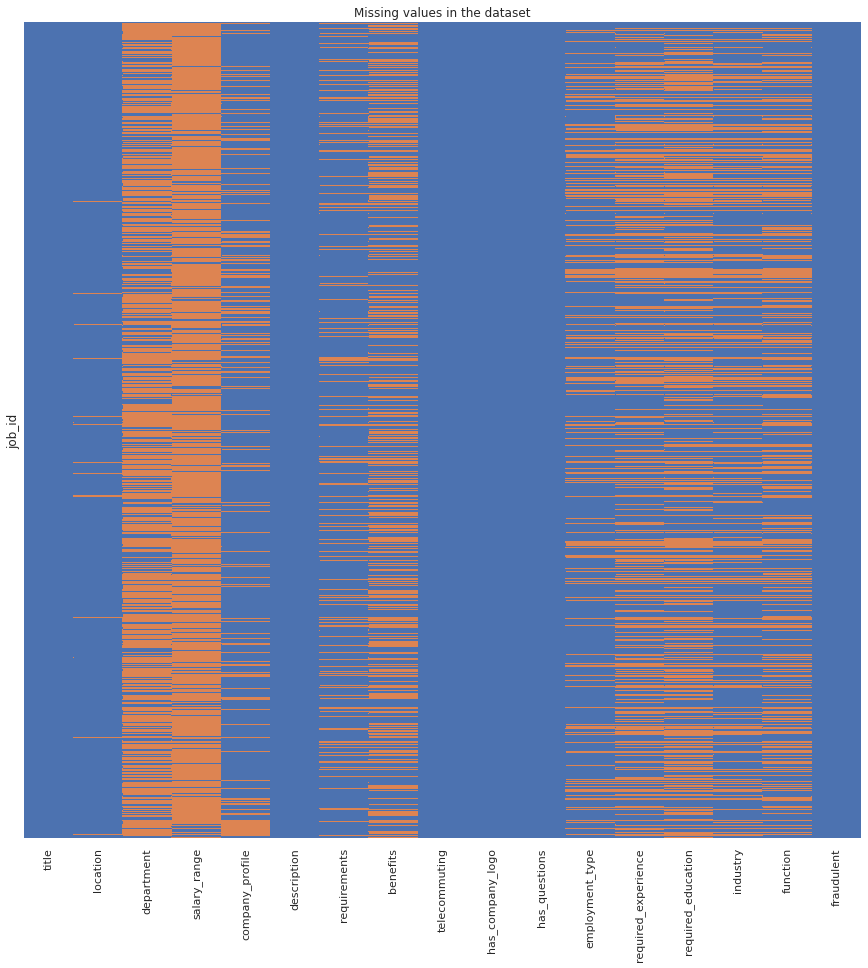

In [9]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[0],sns.color_palette()[1]]);
plt.title('Missing values in the dataset');

17014


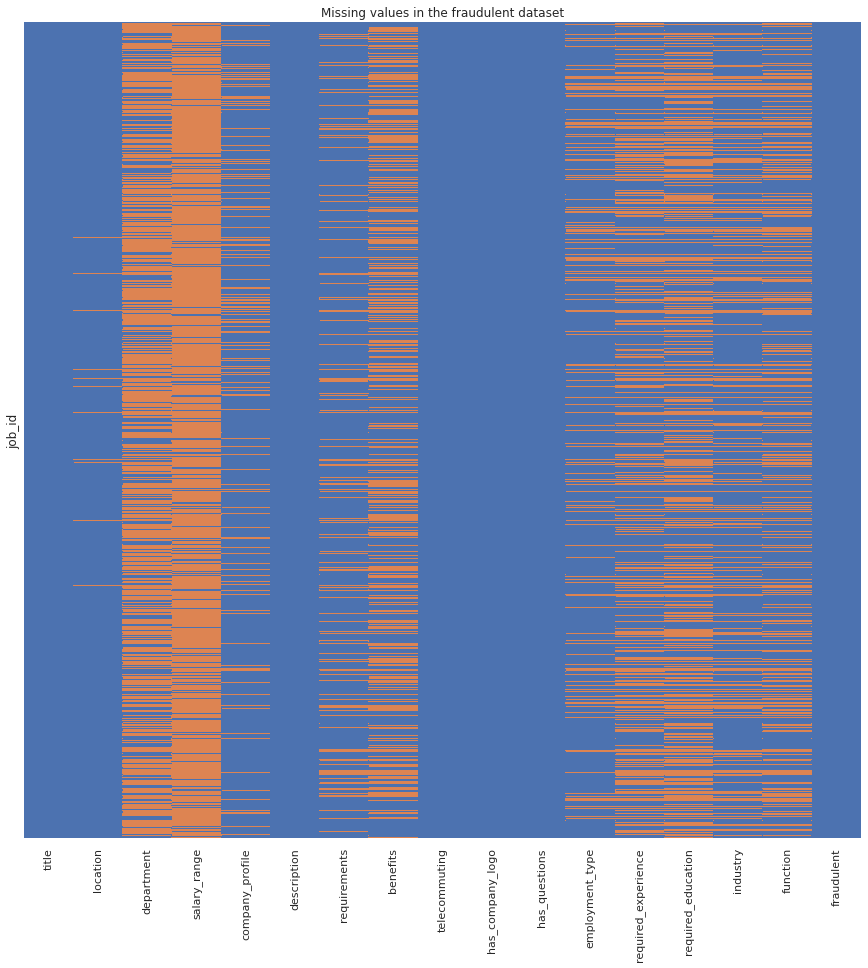

In [10]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[0],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


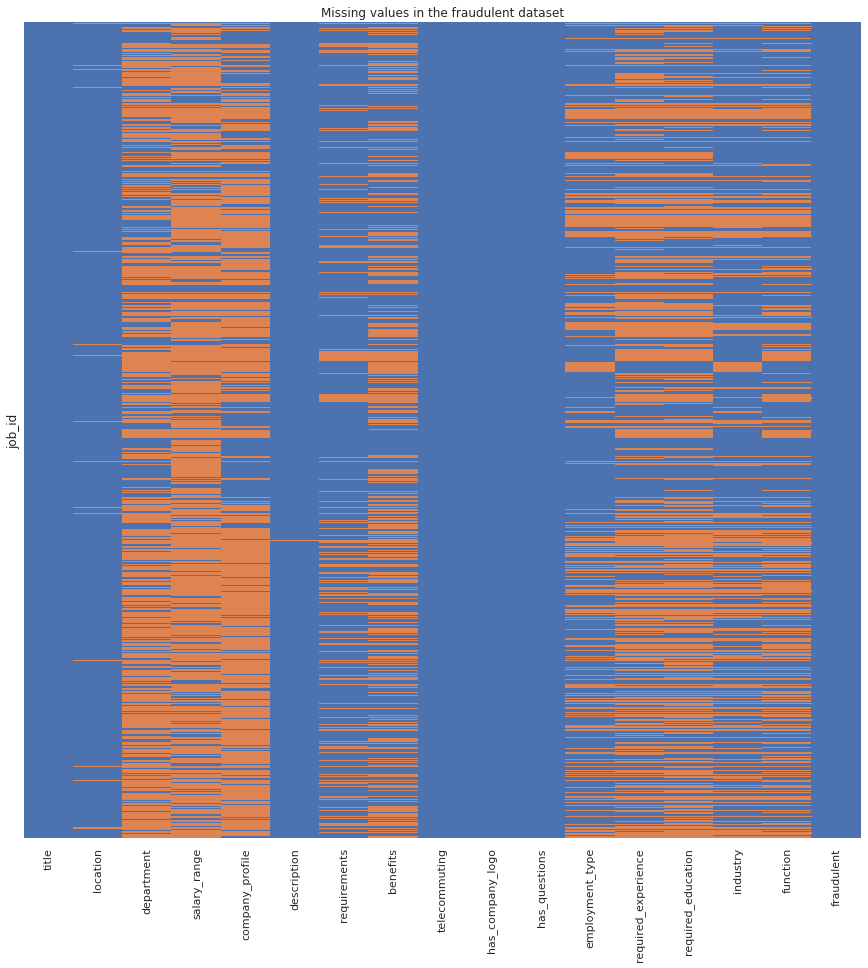

In [11]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[0],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

It seems like the fraudsters are struggling with the company profiles... Let's look at text fields in general to see how creative the fraudsters are.

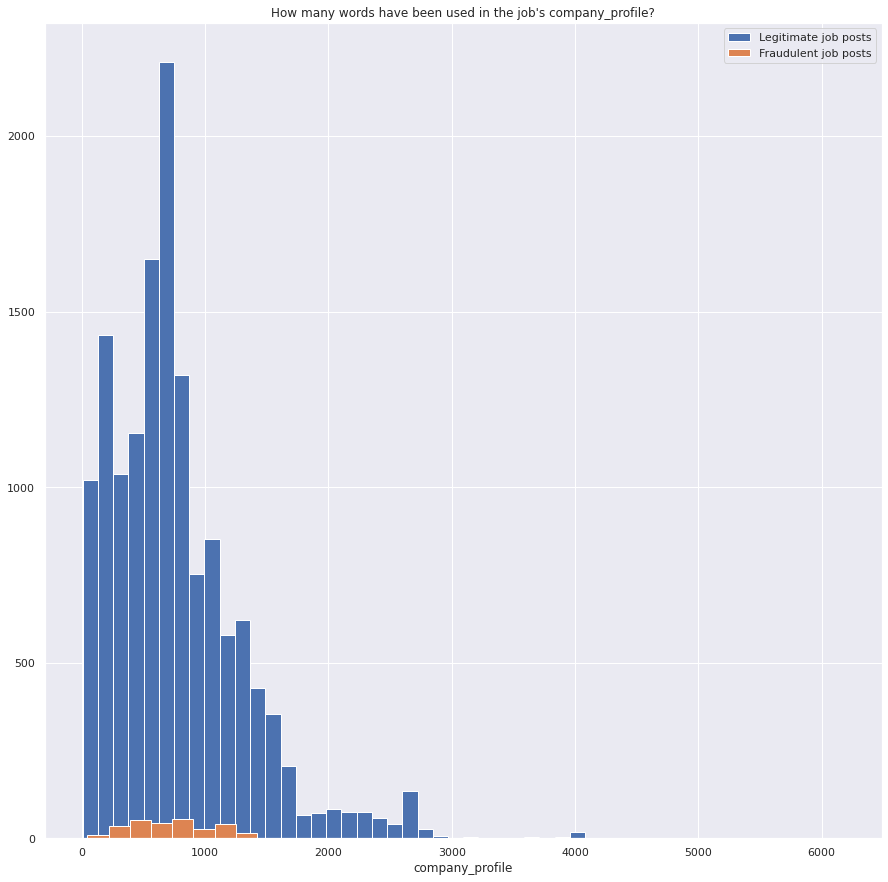

In [12]:
legit_desc_words = dflegit['company_profile'].str.len()
fraud_desc_words = dffraud['company_profile'].str.len()
sns.distplot(legit_desc_words, kde=False, label='Legitimate job posts', color=sns.color_palette()[0], hist_kws={"alpha":1})
sns.distplot(fraud_desc_words, kde=False, label='Fraudulent job posts', color=sns.color_palette()[1], hist_kws={"alpha":1})
plt.title("How many words have been used in the job's company_profile?")
plt.legend();

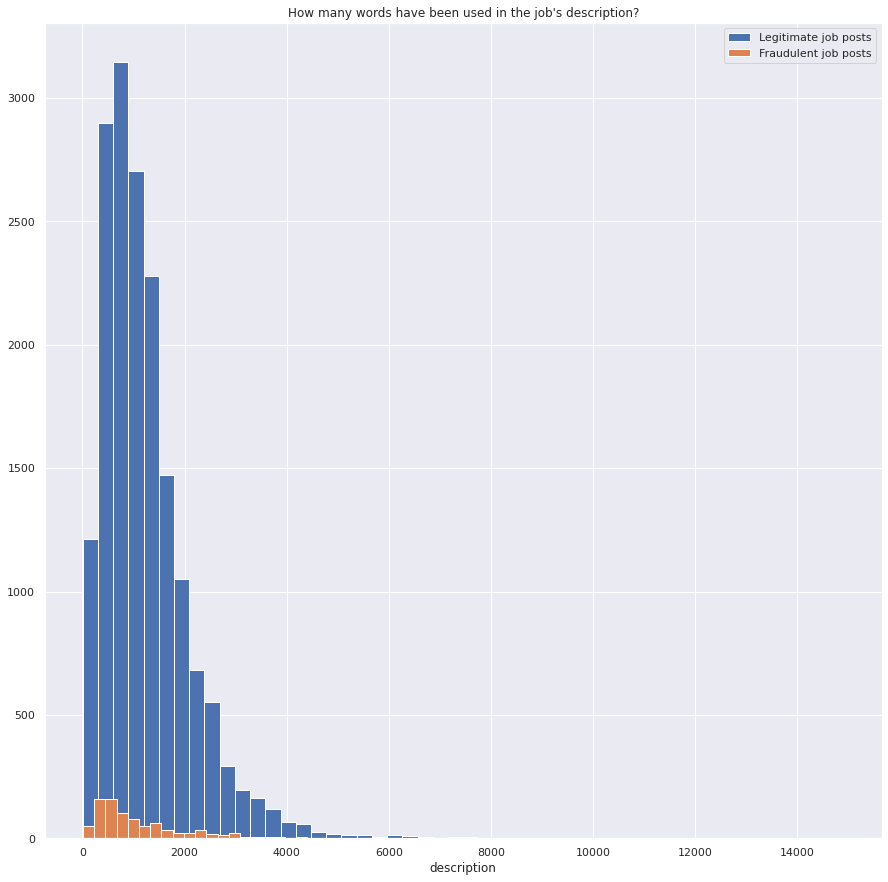

In [13]:
legit_desc_words = dflegit['description'].str.len()
fraud_desc_words = dffraud['description'].str.len()
sns.distplot(legit_desc_words, kde=False, label='Legitimate job posts', color=sns.color_palette()[0], hist_kws={"alpha":1})
sns.distplot(fraud_desc_words, kde=False, label='Fraudulent job posts', color=sns.color_palette()[1], hist_kws={"alpha":1})
plt.title("How many words have been used in the job's description?")
plt.legend();

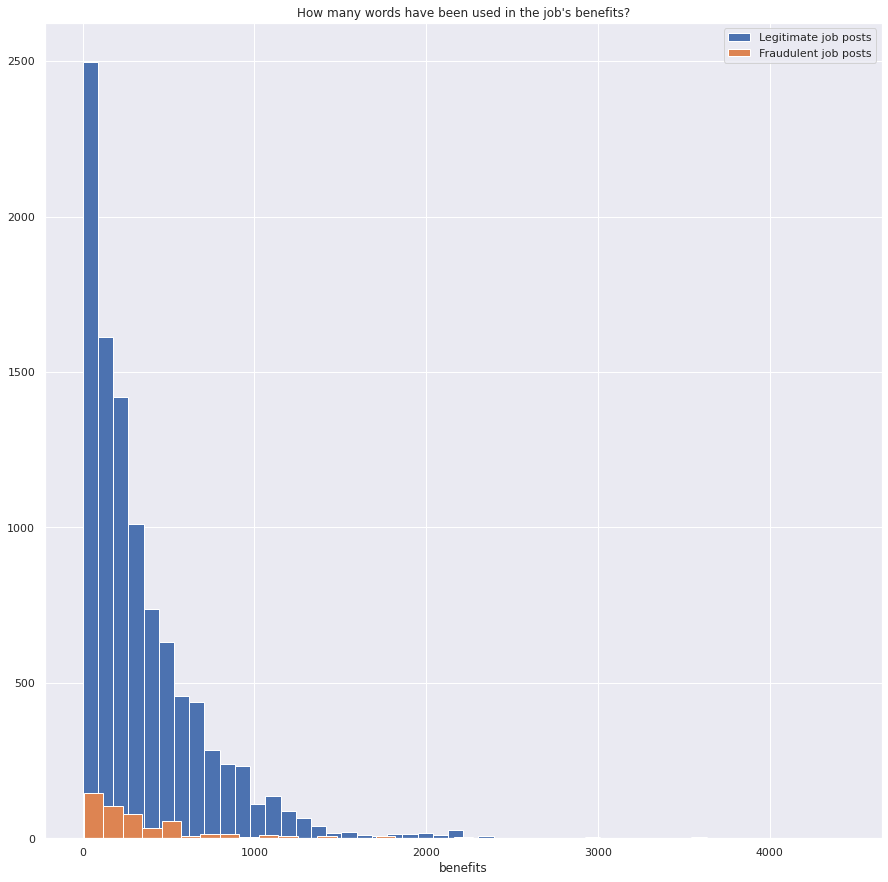

In [14]:
legit_desc_words = dflegit['benefits'].str.len()
fraud_desc_words = dffraud['benefits'].str.len()
sns.distplot(legit_desc_words, kde=False, label='Legitimate job posts', color=sns.color_palette()[0], hist_kws={"alpha":1})
sns.distplot(fraud_desc_words, kde=False, label='Fraudulent job posts', color=sns.color_palette()[1], hist_kws={"alpha":1})
plt.title("How many words have been used in the job's benefits?")
plt.legend();

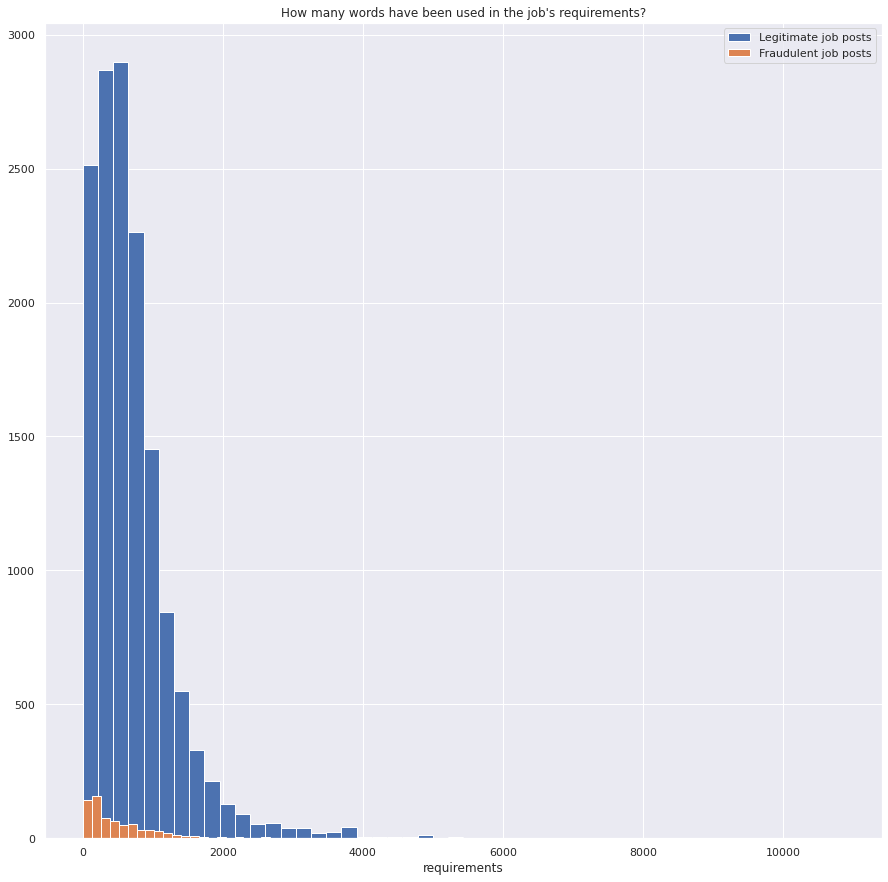

In [15]:
legit_desc_words = dflegit['requirements'].str.len()
fraud_desc_words = dffraud['requirements'].str.len()
sns.distplot(legit_desc_words, kde=False, label='Legitimate job posts', color=sns.color_palette()[0], hist_kws={"alpha":1})
sns.distplot(fraud_desc_words, kde=False, label='Fraudulent job posts', color=sns.color_palette()[1], hist_kws={"alpha":1})
plt.title("How many words have been used in the job's requirements?")
plt.legend();

The fraudster is a man of few words! Hopefully our model will pick this up.

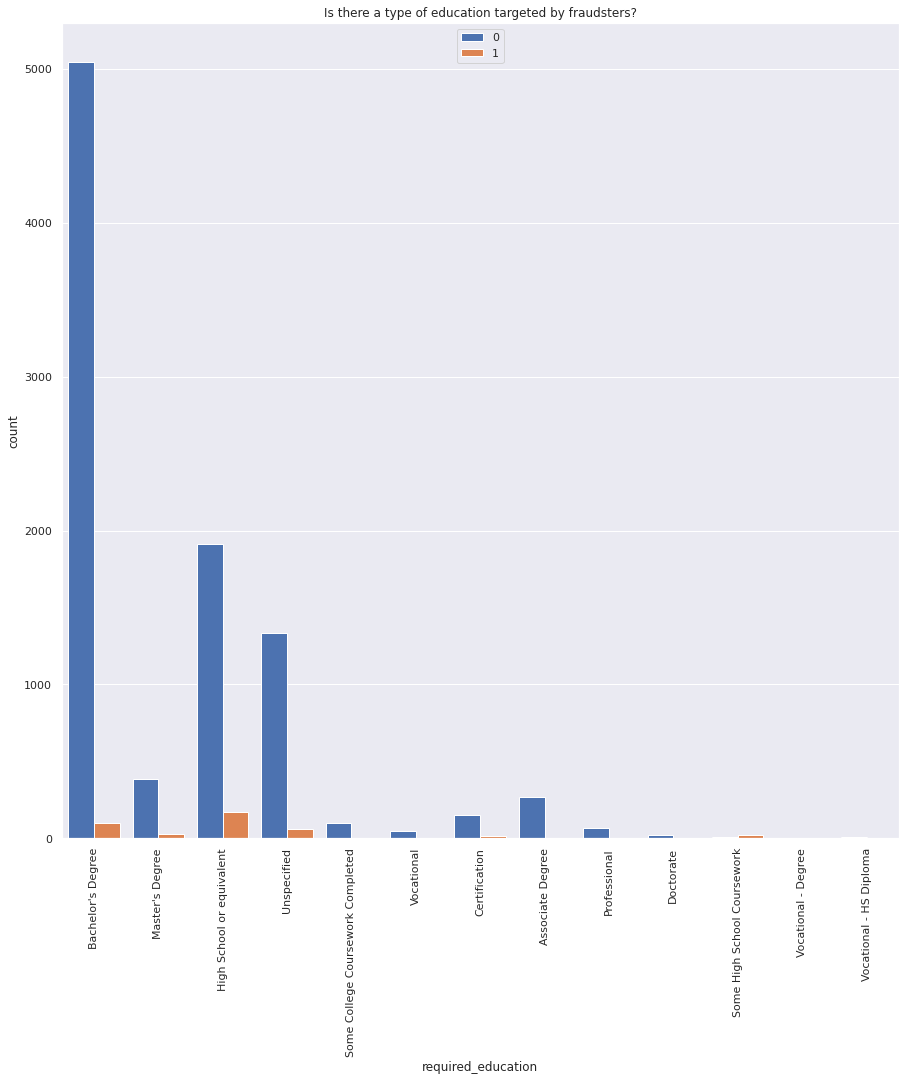

In [16]:
sns.countplot(x='required_education', hue='fraudulent', data=df, saturation=1)
plt.title("Is there a type of education targeted by fraudsters?")
plt.xticks(rotation=90);
plt.legend();

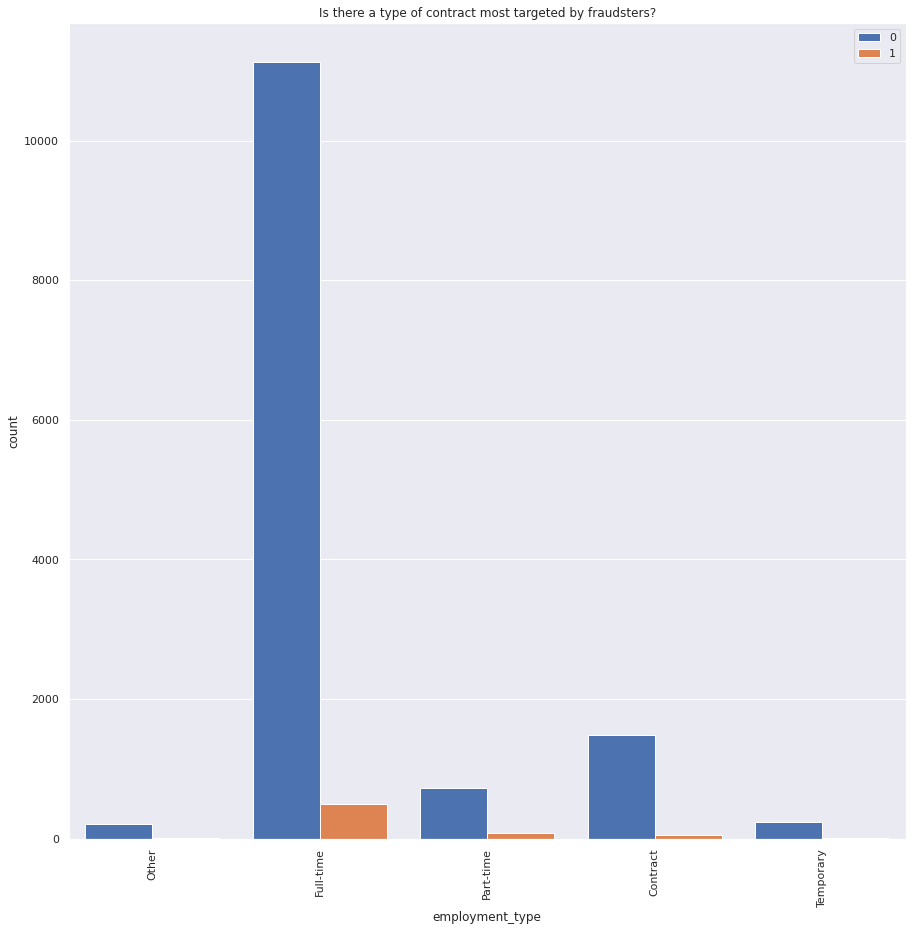

In [17]:
sns.countplot(x='employment_type', hue='fraudulent', data=df, saturation=1)
plt.title("Is there a type of contract most targeted by fraudsters?")
plt.xticks(rotation=90);
plt.legend();

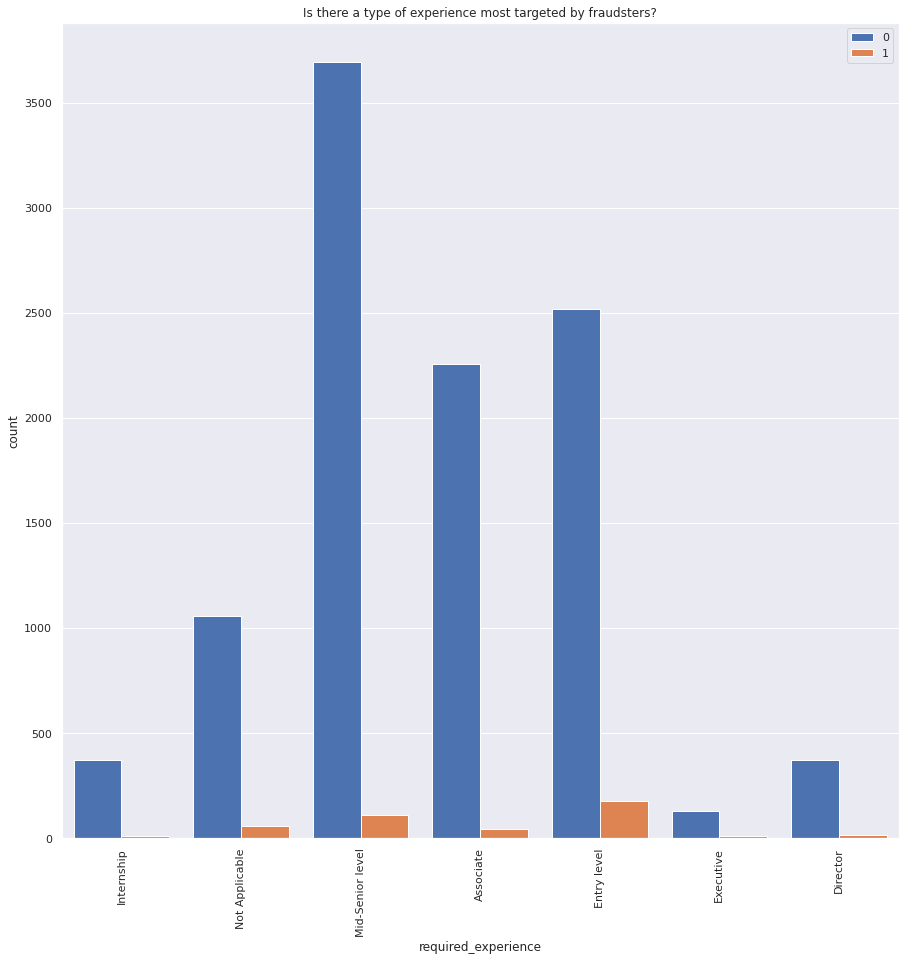

In [18]:
sns.countplot(x='required_experience', hue='fraudulent', data=df, saturation=1)
plt.title("Is there a type of experience most targeted by fraudsters?")
plt.xticks(rotation=90);
plt.legend();

It seems the most exposed job seeker is going to be a entry level high schooler looking for a full time job!

In [19]:
set(df['location'])

{nan,
 'US, IN, North West',
 'US, TN, BRENTWOOD',
 'US, LA, Harahan',
 'US, CA, Berkeley',
 'GB, LND, Farringdon',
 'US, MO, St. Peters',
 'GR, I, Alimos',
 'GR, , Remote',
 'GB, EAW, london',
 'US, MD, Greenbelt',
 'US, MA, Marlborough',
 'US, IA, Waterloo',
 'NL, DR, Assen',
 'IN, KA, bangalore',
 'PL, , REMOTE',
 'GB, LND, Piccadilly',
 'US, PA, Bloomsburg',
 'GR, I, Glyfada',
 'US, NJ, Brunswick',
 'US, NJ, Basking Ridge',
 'GB, LND, Leyton',
 'GR, I, Marousi - Athens',
 'US, NY, Utica',
 'ZA, EC, Port Elizabeth',
 'GR, I, chalandri',
 'US, , Athens',
 'PK, NW, Peshawer',
 'US, PA, Towanda',
 'GB, LUT, Luton',
 'NL, NH, Hilversum',
 'US, DC, WASHINGTON',
 'US, CA, Ontario',
 'GR, I, Athens ',
 'US, NC, Davidson/Lake Norman Area',
 'US, IL, Bloomington',
 'US, KS, Overland Park',
 'GB, BKM, Milton Keynes',
 'GR, I, Paiania',
 'AU, NSW, Albury',
 'US, NY, PAINTED POST',
 'US, AZ, Glendale',
 'GB, SCT,  Edinburgh',
 'US, IN, Merrillville',
 'GB, LIV, City',
 'GB, YOR, York',
 'US, IN

Location: remove `\t`, expect postcodes,'See the Requirements section for areas and locations available', greek characters, 'Silicon Valley/San Jose\xa0-\xa0Santa Clara', 'Work from home', accents (Quebec), multiple locations (Amsterdam, Rotterdam, The Hague, Utrecht)

Location needs to be consolidated (there a a couple of the same city with different county, etc.)

In [20]:
df[df['location']=='US, CA, BERKELY ']

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
5188,Sales - Sports Advertising Sales,"US, CA, BERKELY",SALES,NaN,Campus Concepts we are a National Sports Marke...,Sales- Sports Advertising - Closers Only Sport...,NaN,NaN,1,1,0,Full-time,Mid-Senior level,NaN,Marketing and Advertising,Sales,0
